In [1]:
import numpy as np
import pandas as pd

In [11]:
item_cats_df = pd.read_csv('../data/input/item_categories.csv')
item_df = pd.read_csv('../data/input/items.csv')
sales_train_df = pd.read_csv('../data/input/sales_train.csv')
sample_submission_df = pd.read_csv('../data/input/sample_submission.csv')
shops_df = pd.read_csv('../data/input/shops.csv')

test = pd.read_csv('../data/input/test.csv')

date_block_num:連続した月の番号。　2013年1月=0, 2013年2月=1, ..., 2015年10月=33  
item_cnt_day:商品の売れた数。目的変数。  
item_id:商品個別の識別子  
sales_train_df以外のデータは必要なし？

# 前処理

In [12]:
train = sales_train_df.copy()
# 日付型に変換
train['date'] = pd.to_datetime(train['date'])
# 負の値を除去
train = train[train['item_price'] > 0].copy()
train = train[train['item_cnt_day'] > 0].copy()

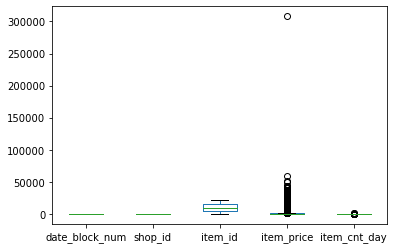

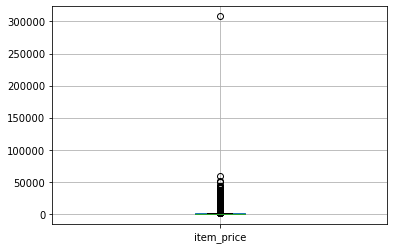

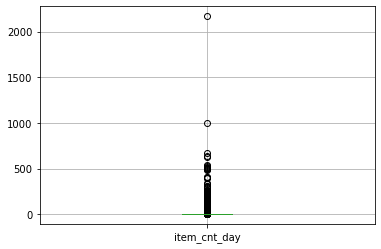

In [13]:
# 外れ値の確認
import matplotlib.pyplot as plt
train.plot.box()
plt.show()
train[['item_price']].boxplot()
plt.show()
train[['item_cnt_day']].boxplot()
plt.show()

In [14]:
# item_priceの外れ値処理
# 四分位範囲
q1 = train['item_price'].quantile(0.25)
q3 = train['item_price'].quantile(0.75)
ipr = q3 - q1
outliner_max1 = q3 + ipr * 1.5
# 標準偏差
outliner_max2 = train['item_price'].mean() + train['item_price'].std() * 2

print(outliner_max1)
print(outliner_max2)

2124.0
4344.463915758676


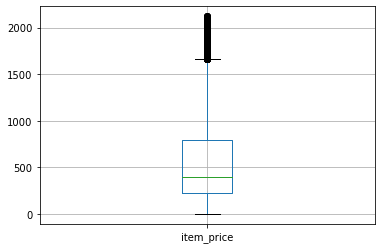

In [15]:
train = train[train['item_price'] < outliner_max1].copy()

train[['item_price']].boxplot()

In [16]:
# item_cnt_dayの外れ値処理
train[train['item_cnt_day'] > 100]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
566159,2013-11-06,5,12,2808,999.000000,200.0
836296,2013-08-29,7,12,2808,999.000000,150.0
868495,2013-05-09,8,25,2808,999.000000,133.0
944059,2013-10-29,9,42,1849,1199.000000,113.0
949279,2013-10-29,9,6,1849,1199.000000,118.0
...,...,...,...,...,...,...
2864262,2015-09-28,32,12,9248,1500.000000,139.0
2864264,2015-09-30,32,12,9244,1296.273292,161.0
2909401,2015-10-14,33,12,20949,4.000000,500.0
2909818,2015-10-28,33,12,11373,0.908714,2169.0


item_cnt_dayに1000以上の異常値がある  
さらにitem_priceが異様に低い商品もある

In [19]:
# item_priceが異様に低い商品について知りたいので、itemのカテゴリをマージ
item_merge_df = pd.merge(item_df, item_cats_df, on='item_category_id', how='inner')
item_merge_df[item_merge_df['item_id'] == 11373]

,item_name,item_id,item_category_id,item_category_name
21966,Доставка до пункта выдачи (Boxberry),11373,9,Доставка товара


In [22]:
# 価格はsales_train_dfにしかないので、そちらを確認
train[train['item_id'] == 11373]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
58323,2013-08-01,0,12,11373,1000.00,1.0
58324,2013-01-31,0,12,11373,97.80,5.0
176790,2013-01-02,1,12,11373,229.00,1.0
176791,2013-04-02,1,12,11373,130.00,1.0
302468,2013-03-29,2,12,11373,139.50,2.0
...,...,...,...,...,...,...
2909829,2015-07-10,33,12,11373,855.00,2.0
2909830,2015-06-10,33,12,11373,208.80,5.0
2909831,2015-05-10,33,12,11373,140.75,16.0
2909832,2015-02-10,33,12,11373,648.50,2.0


商品の価格は変わる

In [29]:
# 商品名、カテゴリ名、日付、価格のdataframeを作成
item_price_df = pd.merge(item_merge_df[['item_name', 'item_category_name', 'item_id']], 
                         train[['date', 'item_price', 'item_id']],
                         on='item_id',
                         how='inner')
item_price_df.head()

,item_name,item_category_name,item_id,date,item_price
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,Кино - DVD,0,2014-01-09,58.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,Кино - DVD,2,2014-08-24,58.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,Кино - DVD,2,2014-12-11,58.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,Кино - DVD,3,2014-05-07,100.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,Кино - DVD,3,2014-08-26,58.0
